# Kernel based qiskit angle images

## Load and preprocess our data

In [7]:
# get pandas running
#import numpy as np
import pandas as pd
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from qiskit import Aer
from qiskit.utils import QuantumInstance

#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

In [27]:
#read in image
import cv2
import os 
print(os.path.exists(r'.\images\vecteezy_snowman-icon-black-and-white_.png'))


# read the image file
img = cv2.imread(r"./images/vecteezy_snowman-icon-black-and-white_.png", cv2.IMREAD_COLOR)
#print(type(img))

# converting to its binary form
ret, img_thres = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

print(type(img_thres))
#print(img_thres)
print(img_thres.shape)

print(img_thres[0][0])
arr=np.ones((200,200))
for y in range(200):
    for x in range(200):
        if img_thres[y][x][0] == 255 and img_thres[y][x][1] == 255 and img_thres[y][x][2] == 255:
            arr[y][x]=-1.0

#print(arr)


True
<class 'numpy.ndarray'>
(200, 200, 3)
[255 255 255]


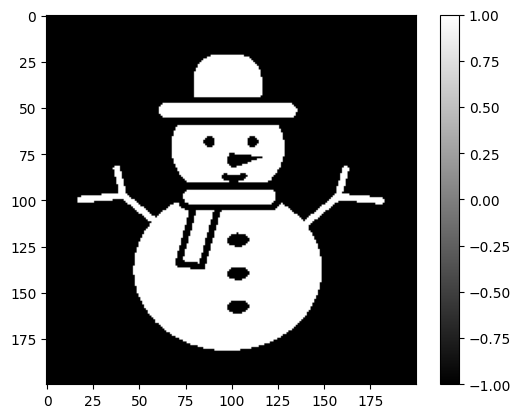

In [28]:
import matplotlib.pyplot as plt

plt.imshow(arr, cmap='gray',vmin=-1.0, vmax=1.0)
plt.colorbar()
plt.show()

In [39]:
#now create our training and test sets
num_samples = 4000
np.random.seed(42)

rand_base = 100000

# input X (0..1, 0..1) y = -1.0,1.0
X = np.random.rand(num_samples,2)
y = np.zeros(num_samples)

for sample in range(num_samples):
    y[sample]=arr[int(X[sample][0]*200)][int(X[sample][1]*200)]
                                                      

In [40]:
from sklearn.model_selection import train_test_split

# split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#y_train = y_train * 2 - np.ones(len(y_train))  # shift label from {0, 1} to {-1, 1}
#y_test = y_test * 2 - np.ones(len(y_test))  # shift label from {0, 1} to {-1, 1}

print(X_train)
print(y_train)

[[0.35883048 0.87720054]
 [0.03778451 0.64336973]
 [0.7199968  0.10116562]
 ...
 [0.14224937 0.12138494]
 [0.50426346 0.86564504]
 [0.59625858 0.70973708]]
[-1. -1. -1. ... -1.  1.  1.]


In [41]:
for i in range(10):
    print("X = {}, Y = {: d}".format(X_train[i], int(y_train[i])))

print("...")

X = [0.35883048 0.87720054], Y = -1
X = [0.03778451 0.64336973], Y = -1
X = [0.7199968  0.10116562], Y = -1
X = [0.70327723 0.83445825], Y = -1
X = [0.46380982 0.1739774 ], Y = -1
X = [0.96292688 0.48354565], Y = -1
X = [0.80348274 0.92922805], Y = -1
X = [0.48501799 0.08540303], Y = -1
X = [0.51832392 0.46180648], Y = -1
X = [0.25566622 0.36456643], Y =  1
...


## Now introduce our kernel

In [42]:
from qiskit import BasicAer
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap

from sklearn.svm import SVC

# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2,
                                 entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map,
                             quantum_instance=BasicAer.get_backend(
                                             'statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(X_train, y_train)
adhoc_svc.score(X_test, y_test)

0.9159090909090909

Score of 0.92. This seems to be quite good!

In [43]:
predictions = adhoc_svc.predict(X_test)

## Now some results

In [44]:
for i in range(10):
    print("X = {}, Y-test = {: d}, Y-predicted = {: d}".format(X_test[i], int(y_test[i]), int(predictions[i])))

print("...")

X = [0.81583312 0.22444057], Y-test = -1, Y-predicted = -1
X = [0.93482204 0.83495678], Y-test = -1, Y-predicted = -1
X = [0.99793411 0.35071182], Y-test = -1, Y-predicted = -1
X = [0.30321955 0.69799047], Y-test = -1, Y-predicted = -1
X = [0.53758114 0.57579247], Y-test =  1, Y-predicted =  1
X = [0.96244729 0.2517823 ], Y-test = -1, Y-predicted = -1
X = [0.97534313 0.81697391], Y-test = -1, Y-predicted = -1
X = [0.0912061 0.4944203], Y-test = -1, Y-predicted = -1
X = [0.37201809 0.77641296], Y-test = -1, Y-predicted = -1
X = [0.06761256 0.80035651], Y-test = -1, Y-predicted = -1
...


In [45]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print('F1 Score: %.3f' % f1_score(y_test, predictions))
print('Accuracy: %.3f' % accuracy_score(y_test, predictions))
print('Recall: %.3f' % recall_score(y_test, predictions))
print('Precision: %.3f' % precision_score(y_test, predictions))


F1 Score: 0.825
Accuracy: 0.916
Recall: 0.845
Precision: 0.806


## Recreate picture from predictions

In [48]:
X_aquidistant = np.zeros((200*200,2))

for y in range(200):
    for x in range(200):
        X_aquidistant[y*200+x][0] = y/200
        X_aquidistant[y*200+x][1] = x/200

print(X_aquidistant)

[[0.    0.   ]
 [0.    0.005]
 [0.    0.01 ]
 ...
 [0.995 0.985]
 [0.995 0.99 ]
 [0.995 0.995]]


In [49]:
y_aquidistant = adhoc_svc.predict(X_aquidistant)

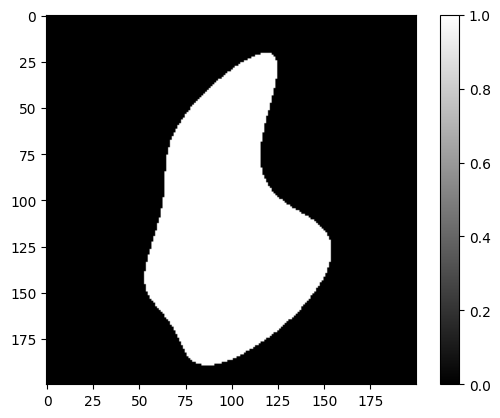

In [50]:
arr2=np.zeros((200,200))

for y in range(200):
    for x in range(200):
        if (y_aquidistant[y*200+x] == 1.0):
            arr2[y][x] = 1.0

import matplotlib.pyplot as plt

plt.imshow(arr2, cmap='gray',vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()

Not bad for first shot with 4000 samples

### now try with 10000 samples :-)

In [64]:
#now create our training and test sets
num_samples = 10000
np.random.seed(42)

rand_base = 100000

# input X (0..1, 0..1) y = -1.0,1.0
X = np.random.rand(num_samples,2)
y = np.zeros(num_samples)

for sample in range(num_samples):
    y[sample]=arr[int(X[sample][0]*200)][int(X[sample][1]*200)]
                                                      

In [65]:
from sklearn.model_selection import train_test_split

# split in train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [66]:
from qiskit import BasicAer
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit.library import ZZFeatureMap

from sklearn.svm import SVC

# Create the quantum feature map
adhoc_feature_map = ZZFeatureMap(feature_dimension=2,
                                 reps=2,
                                 entanglement='linear')
# Create the quantum kernel
adhoc_kernel = QuantumKernel(feature_map=adhoc_feature_map,
                             quantum_instance=BasicAer.get_backend(
                                             'statevector_simulator'))

# Set the SVC algorithm to use our custom kernel
adhoc_svc = SVC(kernel=adhoc_kernel.evaluate)
adhoc_svc.fit(X_train, y_train)
adhoc_svc.score(X_test, y_test)

0.8966666666666666

In [67]:
predictions = adhoc_svc.predict(X_test)

In [68]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print('F1 Score: %.3f' % f1_score(y_test, predictions))
print('Accuracy: %.3f' % accuracy_score(y_test, predictions))
print('Recall: %.3f' % recall_score(y_test, predictions))
print('Precision: %.3f' % precision_score(y_test, predictions))


F1 Score: 0.789
Accuracy: 0.897
Recall: 0.803
Precision: 0.775


In [69]:
X_aquidistant = np.zeros((200*200,2))

for y in range(200):
    for x in range(200):
        X_aquidistant[y*200+x][0] = y/200
        X_aquidistant[y*200+x][1] = x/200

In [70]:
y_aquidistant = adhoc_svc.predict(X_aquidistant)

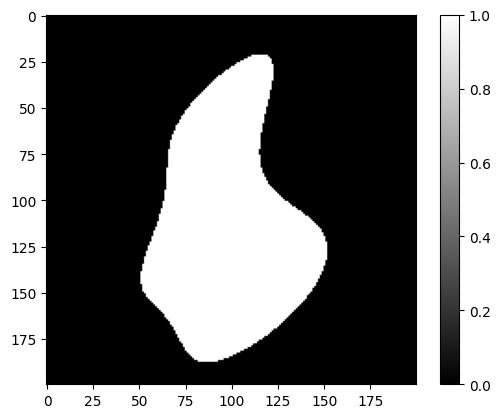

In [71]:
arr2=np.zeros((200,200))

for y in range(200):
    for x in range(200):
        if (y_aquidistant[y*200+x] == 1.0):
            arr2[y][x] = 1.0

import matplotlib.pyplot as plt

plt.imshow(arr2, cmap='gray',vmin=0.0, vmax=1.0)
plt.colorbar()
plt.show()